In [1]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# operações de imagem
import cv2

# outros
import os
import numpy as np
from tqdm import tqdm

In [2]:
from model.model_encoder_deconv import SegNet
from dataset.dataloader_sun_rgbd import train_loader, val_loader, test_loader


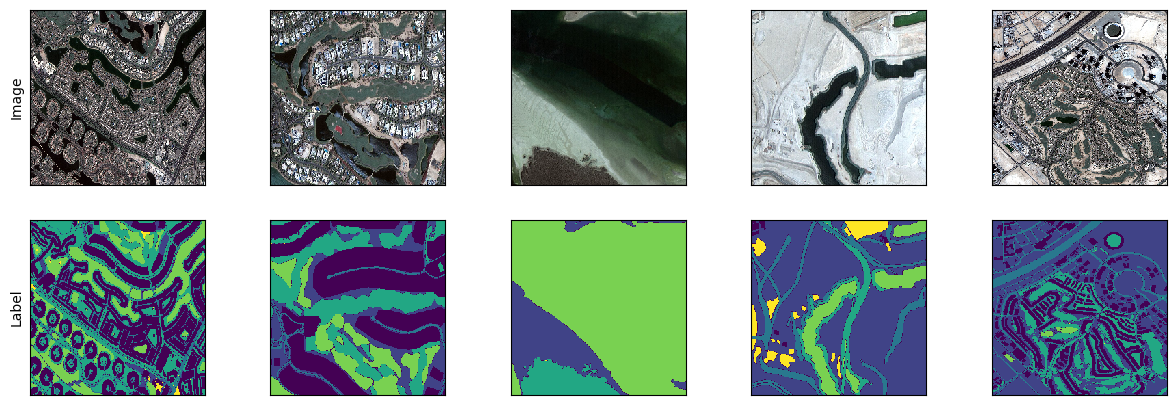

In [3]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
model = SegNet(output_size=6).to(device)
# model.load_state_dict(torch.load(r"model\weights\best_pretrained_bilinear.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
            Conv2d-2          [1, 64, 224, 224]           1,792
              ReLU-3          [1, 64, 224, 224]               0
       BatchNorm2d-4          [1, 64, 224, 224]             128
            Conv2d-5          [1, 64, 224, 224]          36,928
            Conv2d-6          [1, 64, 224, 224]          36,928
              ReLU-7          [1, 64, 224, 224]               0
       BatchNorm2d-8          [1, 64, 224, 224]             128
         MaxPool2d-9          [1, 64, 112, 112]               0
           Conv2d-10         [1, 128, 112, 112]          73,856
           Conv2d-11         [1, 128, 112, 112]          73,856
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
           Conv2d-14         [1, 128, 1

In [6]:
train_losses = list()
valid_losses = list()

In [7]:
EPOCHS = 250
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [9]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("\fLoss: {}\n".format(valid_losses[-1]))
  return best_model

In [10]:
model.freeze_encoder_block()
best_model = train_model()

  0%|          | 1/250 [00:04<20:32,  4.95s/it]

Loss: 1.3602451086044312



  1%|          | 2/250 [00:09<19:25,  4.70s/it]

Loss: 1.3727853298187256



  1%|          | 3/250 [00:14<19:05,  4.64s/it]

Loss: 1.3448423147201538



  2%|▏         | 4/250 [00:18<18:55,  4.62s/it]

Loss: 1.3296902179718018



  2%|▏         | 5/250 [00:23<18:47,  4.60s/it]

Loss: 1.3415472507476807



  2%|▏         | 6/250 [00:27<18:40,  4.59s/it]

Loss: 1.342264175415039



  3%|▎         | 7/250 [00:32<18:31,  4.57s/it]

Loss: 1.3324347734451294



  3%|▎         | 8/250 [00:36<18:24,  4.56s/it]

Loss: 1.329353928565979



  4%|▎         | 9/250 [00:41<18:19,  4.56s/it]

Loss: 1.34039306640625



  4%|▍         | 10/250 [00:45<18:14,  4.56s/it]

Loss: 1.3279751539230347



  4%|▍         | 11/250 [00:50<18:09,  4.56s/it]

Loss: 1.3276071548461914



  5%|▍         | 12/250 [00:55<18:03,  4.55s/it]

Loss: 1.3278772830963135



  5%|▌         | 13/250 [00:59<17:58,  4.55s/it]

Loss: 1.3262485265731812



  6%|▌         | 14/250 [01:04<17:53,  4.55s/it]

Loss: 1.3279916048049927



  6%|▌         | 15/250 [01:08<17:49,  4.55s/it]

Loss: 1.3361107110977173



  6%|▋         | 16/250 [01:13<17:45,  4.55s/it]

Loss: 1.3387006521224976



  7%|▋         | 17/250 [01:17<17:41,  4.55s/it]

Loss: 1.3394228219985962



  7%|▋         | 18/250 [01:22<17:36,  4.55s/it]

Loss: 1.3376950025558472



  8%|▊         | 19/250 [01:26<17:32,  4.56s/it]

Loss: 1.3326901197433472



  8%|▊         | 20/250 [01:31<17:24,  4.54s/it]

Loss: 1.3319147825241089



  8%|▊         | 21/250 [01:35<17:16,  4.53s/it]

Loss: 1.3384935855865479



  9%|▉         | 22/250 [01:40<17:11,  4.52s/it]

Loss: 1.3421887159347534



  9%|▉         | 23/250 [01:44<17:04,  4.51s/it]

Loss: 1.3373531103134155



 10%|▉         | 24/250 [01:49<16:59,  4.51s/it]

Loss: 1.334753394126892



 10%|█         | 25/250 [01:53<16:53,  4.50s/it]

Loss: 1.3329975605010986



 10%|█         | 26/250 [01:58<16:49,  4.51s/it]

Loss: 1.325885534286499



 11%|█         | 27/250 [02:02<16:44,  4.50s/it]

Loss: 1.3258968591690063



 11%|█         | 28/250 [02:07<16:38,  4.50s/it]

Loss: 1.328307032585144



 12%|█▏        | 29/250 [02:11<16:33,  4.50s/it]

Loss: 1.3309320211410522



 12%|█▏        | 30/250 [02:16<16:30,  4.50s/it]

Loss: 1.3370143175125122



 12%|█▏        | 31/250 [02:20<16:25,  4.50s/it]

Loss: 1.337328314781189



 13%|█▎        | 32/250 [02:25<16:39,  4.58s/it]

Loss: 1.3374576568603516



 13%|█▎        | 33/250 [02:30<16:46,  4.64s/it]

Loss: 1.3322553634643555



 14%|█▎        | 34/250 [02:34<16:32,  4.59s/it]

Loss: 1.3255211114883423



 14%|█▍        | 35/250 [02:39<16:17,  4.55s/it]

Loss: 1.3345184326171875



 14%|█▍        | 36/250 [02:43<16:06,  4.52s/it]

Loss: 1.3469511270523071



 15%|█▍        | 37/250 [02:48<15:56,  4.49s/it]

Loss: 1.3518879413604736



 15%|█▌        | 38/250 [02:52<15:48,  4.47s/it]

Loss: 1.3511619567871094



 16%|█▌        | 39/250 [02:57<15:41,  4.46s/it]

Loss: 1.3425432443618774



 16%|█▌        | 40/250 [03:01<15:34,  4.45s/it]

Loss: 1.3344838619232178



 16%|█▋        | 41/250 [03:05<15:28,  4.44s/it]

Loss: 1.331008791923523



 17%|█▋        | 42/250 [03:10<15:22,  4.44s/it]

Loss: 1.32871675491333



 17%|█▋        | 43/250 [03:14<15:17,  4.43s/it]

Loss: 1.3402127027511597



 18%|█▊        | 44/250 [03:19<15:12,  4.43s/it]

Loss: 1.3514378070831299



 18%|█▊        | 45/250 [03:23<15:09,  4.44s/it]

Loss: 1.3529239892959595



 18%|█▊        | 46/250 [03:28<15:05,  4.44s/it]

Loss: 1.3510178327560425



 19%|█▉        | 47/250 [03:32<15:01,  4.44s/it]

Loss: 1.3447020053863525



 19%|█▉        | 48/250 [03:37<14:55,  4.43s/it]

Loss: 1.3362088203430176



 20%|█▉        | 49/250 [03:41<14:50,  4.43s/it]

Loss: 1.3307031393051147



 20%|██        | 50/250 [03:45<14:45,  4.43s/it]

Loss: 1.329630732536316



 20%|██        | 51/250 [03:50<14:41,  4.43s/it]

Loss: 1.3301090002059937



 21%|██        | 52/250 [03:54<14:36,  4.43s/it]

Loss: 1.3306180238723755



 21%|██        | 53/250 [03:59<14:32,  4.43s/it]

Loss: 1.336251974105835



 22%|██▏       | 54/250 [04:03<14:28,  4.43s/it]

Loss: 1.3434022665023804



 22%|██▏       | 55/250 [04:08<14:23,  4.43s/it]

Loss: 1.3467978239059448



 22%|██▏       | 56/250 [04:12<14:19,  4.43s/it]

Loss: 1.345211386680603



 23%|██▎       | 57/250 [04:16<14:14,  4.43s/it]

Loss: 1.3388779163360596



 23%|██▎       | 58/250 [04:21<14:11,  4.44s/it]

Loss: 1.3308930397033691



 24%|██▎       | 59/250 [04:25<14:08,  4.44s/it]

Loss: 1.3301962614059448



 24%|██▍       | 60/250 [04:30<14:04,  4.44s/it]

Loss: 1.3325620889663696



 24%|██▍       | 61/250 [04:34<13:58,  4.44s/it]

Loss: 1.329514980316162



 25%|██▍       | 62/250 [04:39<13:55,  4.44s/it]

Loss: 1.3256381750106812



 25%|██▌       | 63/250 [04:43<13:50,  4.44s/it]

Loss: 1.323691487312317



 26%|██▌       | 64/250 [04:48<13:46,  4.44s/it]

Loss: 1.3251018524169922



 26%|██▌       | 65/250 [04:52<13:41,  4.44s/it]

Loss: 1.3310590982437134



 26%|██▋       | 66/250 [04:56<13:37,  4.44s/it]

Loss: 1.3394545316696167



 27%|██▋       | 67/250 [05:01<13:33,  4.44s/it]

Loss: 1.3493798971176147



 27%|██▋       | 68/250 [05:05<13:29,  4.45s/it]

Loss: 1.3536018133163452



 28%|██▊       | 69/250 [05:10<13:23,  4.44s/it]

Loss: 1.3556612730026245



 28%|██▊       | 70/250 [05:14<13:19,  4.44s/it]

Loss: 1.3539007902145386



 28%|██▊       | 71/250 [05:19<13:14,  4.44s/it]

Loss: 1.342474341392517



 29%|██▉       | 72/250 [05:23<13:09,  4.44s/it]

Loss: 1.332859992980957



 29%|██▉       | 73/250 [05:27<13:05,  4.44s/it]

Loss: 1.330466866493225



 30%|██▉       | 74/250 [05:32<13:01,  4.44s/it]

Loss: 1.3319851160049438



 30%|███       | 75/250 [05:36<12:56,  4.44s/it]

Loss: 1.336565613746643



 30%|███       | 76/250 [05:41<12:52,  4.44s/it]

Loss: 1.343059778213501



 31%|███       | 77/250 [05:45<12:48,  4.44s/it]

Loss: 1.3487229347229004



 31%|███       | 78/250 [05:50<12:45,  4.45s/it]

Loss: 1.3510299921035767



 32%|███▏      | 79/250 [05:54<12:41,  4.45s/it]

Loss: 1.351727843284607



 32%|███▏      | 80/250 [05:59<12:36,  4.45s/it]

Loss: 1.350458025932312



 32%|███▏      | 81/250 [06:03<12:32,  4.45s/it]

Loss: 1.3488521575927734



 33%|███▎      | 82/250 [06:08<12:27,  4.45s/it]

Loss: 1.3468973636627197



 33%|███▎      | 83/250 [06:12<12:21,  4.44s/it]

Loss: 1.3450044393539429



 34%|███▎      | 84/250 [06:16<12:18,  4.45s/it]

Loss: 1.340554118156433



 34%|███▍      | 85/250 [06:21<12:14,  4.45s/it]

Loss: 1.3349686861038208



 34%|███▍      | 86/250 [06:25<12:09,  4.45s/it]

Loss: 1.3325196504592896



 35%|███▍      | 87/250 [06:30<12:04,  4.44s/it]

Loss: 1.3336060047149658



 35%|███▌      | 88/250 [06:34<11:59,  4.44s/it]

Loss: 1.3399828672409058



 36%|███▌      | 89/250 [06:39<11:55,  4.44s/it]

Loss: 1.3522900342941284



 36%|███▌      | 90/250 [06:43<11:51,  4.45s/it]

Loss: 1.3580080270767212



 36%|███▋      | 91/250 [06:48<11:46,  4.44s/it]

Loss: 1.344194769859314



 37%|███▋      | 92/250 [06:52<11:43,  4.45s/it]

Loss: 1.3260525465011597



 37%|███▋      | 93/250 [06:56<11:38,  4.45s/it]

Loss: 1.3233730792999268



 38%|███▊      | 94/250 [07:01<11:34,  4.45s/it]

Loss: 1.3224422931671143



 38%|███▊      | 95/250 [07:05<11:29,  4.45s/it]

Loss: 1.3230977058410645



 38%|███▊      | 96/250 [07:10<11:24,  4.45s/it]

Loss: 1.326828956604004



 39%|███▉      | 97/250 [07:14<11:19,  4.44s/it]

Loss: 1.3330039978027344



 39%|███▉      | 98/250 [07:19<11:15,  4.44s/it]

Loss: 1.3393257856369019



 40%|███▉      | 99/250 [07:23<11:10,  4.44s/it]

Loss: 1.3405178785324097



 40%|████      | 100/250 [07:27<11:05,  4.44s/it]

Loss: 1.3384974002838135



 40%|████      | 101/250 [07:32<11:01,  4.44s/it]

Loss: 1.3353302478790283



 41%|████      | 102/250 [07:36<10:56,  4.43s/it]

Loss: 1.331908106803894



 41%|████      | 103/250 [07:41<10:52,  4.44s/it]

Loss: 1.3289048671722412



 42%|████▏     | 104/250 [07:45<10:48,  4.44s/it]

Loss: 1.3277043104171753



 42%|████▏     | 105/250 [07:50<10:43,  4.44s/it]

Loss: 1.3253631591796875



 42%|████▏     | 106/250 [07:54<10:39,  4.44s/it]

Loss: 1.3222007751464844



 43%|████▎     | 107/250 [07:59<10:35,  4.44s/it]

Loss: 1.3213647603988647



 43%|████▎     | 108/250 [08:03<10:30,  4.44s/it]

Loss: 1.320478916168213



 44%|████▎     | 109/250 [08:07<10:26,  4.44s/it]

Loss: 1.321253776550293



 44%|████▍     | 110/250 [08:12<10:21,  4.44s/it]

Loss: 1.3212493658065796



 44%|████▍     | 111/250 [08:16<10:17,  4.44s/it]

Loss: 1.3212002515792847



 45%|████▍     | 112/250 [08:21<10:12,  4.44s/it]

Loss: 1.321926474571228



 45%|████▌     | 113/250 [08:25<10:09,  4.45s/it]

Loss: 1.3245517015457153



 46%|████▌     | 114/250 [08:30<10:04,  4.44s/it]

Loss: 1.3254667520523071



 46%|████▌     | 115/250 [08:34<10:00,  4.44s/it]

Loss: 1.3235238790512085



 46%|████▋     | 116/250 [08:39<09:55,  4.44s/it]

Loss: 1.321126937866211



 47%|████▋     | 117/250 [08:43<09:51,  4.44s/it]

Loss: 1.3209377527236938



 47%|████▋     | 118/250 [08:47<09:46,  4.44s/it]

Loss: 1.3199619054794312



 48%|████▊     | 119/250 [08:52<09:42,  4.44s/it]

Loss: 1.318867564201355



 48%|████▊     | 120/250 [08:56<09:37,  4.44s/it]

Loss: 1.319698691368103



 48%|████▊     | 121/250 [09:01<09:32,  4.44s/it]

Loss: 1.3221912384033203



 49%|████▉     | 122/250 [09:05<09:28,  4.44s/it]

Loss: 1.3249763250350952



 49%|████▉     | 123/250 [09:10<09:23,  4.44s/it]

Loss: 1.3245205879211426



 50%|████▉     | 124/250 [09:14<09:18,  4.43s/it]

Loss: 1.3233413696289062



 50%|█████     | 125/250 [09:18<09:14,  4.43s/it]

Loss: 1.3221485614776611



 50%|█████     | 126/250 [09:23<09:09,  4.43s/it]

Loss: 1.321040391921997



 51%|█████     | 127/250 [09:27<09:05,  4.44s/it]

Loss: 1.3190529346466064



 51%|█████     | 128/250 [09:32<09:01,  4.44s/it]

Loss: 1.3167418241500854



 52%|█████▏    | 129/250 [09:36<08:57,  4.44s/it]

Loss: 1.316340446472168



 52%|█████▏    | 130/250 [09:41<08:52,  4.44s/it]

Loss: 1.3185995817184448



 52%|█████▏    | 131/250 [09:45<08:48,  4.44s/it]

Loss: 1.3205124139785767



 53%|█████▎    | 132/250 [09:50<08:44,  4.44s/it]

Loss: 1.3198184967041016



 53%|█████▎    | 133/250 [09:54<08:40,  4.45s/it]

Loss: 1.3191708326339722



 54%|█████▎    | 134/250 [09:59<08:36,  4.45s/it]

Loss: 1.3216946125030518



 54%|█████▍    | 135/250 [10:03<08:31,  4.45s/it]

Loss: 1.3235101699829102



 54%|█████▍    | 136/250 [10:07<08:27,  4.45s/it]

Loss: 1.3223536014556885



 55%|█████▍    | 137/250 [10:12<08:22,  4.45s/it]

Loss: 1.3195451498031616



 55%|█████▌    | 138/250 [10:16<08:18,  4.45s/it]

Loss: 1.3173094987869263



 56%|█████▌    | 139/250 [10:21<08:14,  4.45s/it]

Loss: 1.3158730268478394



 56%|█████▌    | 140/250 [10:25<08:09,  4.45s/it]

Loss: 1.3135091066360474



 56%|█████▋    | 141/250 [10:30<08:05,  4.45s/it]

Loss: 1.3110159635543823



 57%|█████▋    | 142/250 [10:34<08:00,  4.45s/it]

Loss: 1.3090837001800537



 57%|█████▋    | 143/250 [10:39<07:56,  4.45s/it]

Loss: 1.3082313537597656



 58%|█████▊    | 144/250 [10:43<07:51,  4.45s/it]

Loss: 1.3096389770507812



 58%|█████▊    | 145/250 [10:47<07:47,  4.45s/it]

Loss: 1.313306212425232



 58%|█████▊    | 146/250 [10:52<07:43,  4.46s/it]

Loss: 1.318398356437683



 59%|█████▉    | 147/250 [10:56<07:38,  4.45s/it]

Loss: 1.3237576484680176



 59%|█████▉    | 148/250 [11:01<07:34,  4.45s/it]

Loss: 1.327743411064148



 60%|█████▉    | 149/250 [11:05<07:29,  4.45s/it]

Loss: 1.3276340961456299



 60%|██████    | 150/250 [11:10<07:24,  4.44s/it]

Loss: 1.3244537115097046



 60%|██████    | 151/250 [11:14<07:20,  4.45s/it]

Loss: 1.3186012506484985



 61%|██████    | 152/250 [11:19<07:15,  4.44s/it]

Loss: 1.3141196966171265



 61%|██████    | 153/250 [11:23<07:10,  4.44s/it]

Loss: 1.3112486600875854



 62%|██████▏   | 154/250 [11:27<07:06,  4.44s/it]

Loss: 1.3102991580963135



 62%|██████▏   | 155/250 [11:32<07:02,  4.44s/it]

Loss: 1.3130576610565186



 62%|██████▏   | 156/250 [11:36<06:57,  4.45s/it]

Loss: 1.3161925077438354



 63%|██████▎   | 157/250 [11:41<06:53,  4.45s/it]

Loss: 1.318932294845581



 63%|██████▎   | 158/250 [11:45<06:49,  4.45s/it]

Loss: 1.3206671476364136



 64%|██████▎   | 159/250 [11:50<06:44,  4.44s/it]

Loss: 1.3200534582138062



 64%|██████▍   | 160/250 [11:54<06:40,  4.45s/it]

Loss: 1.316580057144165



 64%|██████▍   | 161/250 [11:59<06:36,  4.45s/it]

Loss: 1.314625859260559



 65%|██████▍   | 162/250 [12:03<06:31,  4.45s/it]

Loss: 1.316509485244751



 65%|██████▌   | 163/250 [12:08<06:27,  4.46s/it]

Loss: 1.3158025741577148



 66%|██████▌   | 164/250 [12:12<06:22,  4.45s/it]

Loss: 1.313607931137085



 66%|██████▌   | 165/250 [12:16<06:18,  4.45s/it]

Loss: 1.3132907152175903



 66%|██████▋   | 166/250 [12:21<06:14,  4.45s/it]

Loss: 1.3151905536651611



 67%|██████▋   | 167/250 [12:25<06:09,  4.46s/it]

Loss: 1.3171762228012085



 67%|██████▋   | 168/250 [12:30<06:05,  4.45s/it]

Loss: 1.3177345991134644



 68%|██████▊   | 169/250 [12:34<06:00,  4.45s/it]

Loss: 1.3175491094589233



 68%|██████▊   | 170/250 [12:39<05:56,  4.45s/it]

Loss: 1.3175204992294312



 68%|██████▊   | 171/250 [12:43<05:51,  4.45s/it]

Loss: 1.3179714679718018



 69%|██████▉   | 172/250 [12:48<05:46,  4.45s/it]

Loss: 1.318536639213562



 69%|██████▉   | 173/250 [12:52<05:42,  4.45s/it]

Loss: 1.31839120388031



 70%|██████▉   | 174/250 [12:56<05:38,  4.45s/it]

Loss: 1.318121314048767



 70%|███████   | 175/250 [13:01<05:33,  4.45s/it]

Loss: 1.3187837600708008



 70%|███████   | 176/250 [13:05<05:29,  4.45s/it]

Loss: 1.3197399377822876



 71%|███████   | 177/250 [13:10<05:24,  4.44s/it]

Loss: 1.3190330266952515



 71%|███████   | 178/250 [13:14<05:19,  4.44s/it]

Loss: 1.3175181150436401



 72%|███████▏  | 179/250 [13:19<05:15,  4.44s/it]

Loss: 1.3159502744674683



 72%|███████▏  | 180/250 [13:23<05:10,  4.44s/it]

Loss: 1.315395712852478



 72%|███████▏  | 181/250 [13:28<05:06,  4.44s/it]

Loss: 1.3170794248580933



 73%|███████▎  | 182/250 [13:32<05:02,  4.45s/it]

Loss: 1.3216320276260376



 73%|███████▎  | 183/250 [13:36<04:58,  4.45s/it]

Loss: 1.3270543813705444



 74%|███████▎  | 184/250 [13:41<04:53,  4.45s/it]

Loss: 1.3311668634414673



 74%|███████▍  | 185/250 [13:45<04:49,  4.45s/it]

Loss: 1.333778977394104



 74%|███████▍  | 186/250 [13:50<04:44,  4.45s/it]

Loss: 1.3342798948287964



 75%|███████▍  | 187/250 [13:54<04:39,  4.44s/it]

Loss: 1.332304835319519



 75%|███████▌  | 188/250 [13:59<04:35,  4.45s/it]

Loss: 1.328090786933899



 76%|███████▌  | 189/250 [14:03<04:31,  4.44s/it]

Loss: 1.3230557441711426



 76%|███████▌  | 190/250 [14:08<04:26,  4.45s/it]

Loss: 1.3189786672592163



 76%|███████▋  | 191/250 [14:12<04:22,  4.45s/it]

Loss: 1.3159852027893066



 77%|███████▋  | 192/250 [14:17<04:18,  4.45s/it]

Loss: 1.3142942190170288



 77%|███████▋  | 193/250 [14:21<04:13,  4.45s/it]

Loss: 1.314374327659607



 78%|███████▊  | 194/250 [14:25<04:09,  4.45s/it]

Loss: 1.317016839981079



 78%|███████▊  | 195/250 [14:30<04:05,  4.46s/it]

Loss: 1.323958158493042



 78%|███████▊  | 196/250 [14:34<04:00,  4.45s/it]

Loss: 1.3329461812973022



 79%|███████▉  | 197/250 [14:39<03:55,  4.45s/it]

Loss: 1.3422740697860718



 79%|███████▉  | 198/250 [14:43<03:51,  4.45s/it]

Loss: 1.3446485996246338



 80%|███████▉  | 199/250 [14:48<03:46,  4.44s/it]

Loss: 1.3406567573547363



 80%|████████  | 200/250 [14:52<03:42,  4.45s/it]

Loss: 1.3323205709457397



 80%|████████  | 201/250 [14:57<03:38,  4.45s/it]

Loss: 1.323872685432434



 81%|████████  | 202/250 [15:01<03:33,  4.44s/it]

Loss: 1.3174139261245728



 81%|████████  | 203/250 [15:05<03:28,  4.44s/it]

Loss: 1.313215970993042



 82%|████████▏ | 204/250 [15:10<03:24,  4.44s/it]

Loss: 1.310711145401001



 82%|████████▏ | 205/250 [15:14<03:19,  4.44s/it]

Loss: 1.310756802558899



 82%|████████▏ | 206/250 [15:19<03:15,  4.44s/it]

Loss: 1.312423586845398



 83%|████████▎ | 207/250 [15:23<03:10,  4.44s/it]

Loss: 1.3147530555725098



 83%|████████▎ | 208/250 [15:28<03:06,  4.44s/it]

Loss: 1.3173390626907349



 84%|████████▎ | 209/250 [15:32<03:02,  4.44s/it]

Loss: 1.3193559646606445



 84%|████████▍ | 210/250 [15:36<02:57,  4.44s/it]

Loss: 1.3209730386734009



 84%|████████▍ | 211/250 [15:41<02:53,  4.44s/it]

Loss: 1.3226333856582642



 85%|████████▍ | 212/250 [15:45<02:48,  4.44s/it]

Loss: 1.3240947723388672



 85%|████████▌ | 213/250 [15:50<02:44,  4.44s/it]

Loss: 1.3271178007125854



 86%|████████▌ | 214/250 [15:54<02:40,  4.45s/it]

Loss: 1.3282142877578735



 86%|████████▌ | 215/250 [15:59<02:35,  4.45s/it]

Loss: 1.3268458843231201



 86%|████████▋ | 216/250 [16:03<02:31,  4.45s/it]

Loss: 1.3245961666107178



 87%|████████▋ | 217/250 [16:08<02:26,  4.44s/it]

Loss: 1.3204176425933838



 87%|████████▋ | 218/250 [16:12<02:22,  4.45s/it]

Loss: 1.3154319524765015



 88%|████████▊ | 219/250 [16:16<02:17,  4.44s/it]

Loss: 1.3117287158966064



 88%|████████▊ | 220/250 [16:21<02:13,  4.45s/it]

Loss: 1.309402346611023



 88%|████████▊ | 221/250 [16:25<02:08,  4.44s/it]

Loss: 1.308678150177002



 89%|████████▉ | 222/250 [16:30<02:04,  4.45s/it]

Loss: 1.3097190856933594



 89%|████████▉ | 223/250 [16:34<02:00,  4.44s/it]

Loss: 1.3121930360794067



 90%|████████▉ | 224/250 [16:39<01:55,  4.44s/it]

Loss: 1.3165247440338135



 90%|█████████ | 225/250 [16:43<01:51,  4.44s/it]

Loss: 1.3215221166610718



 90%|█████████ | 226/250 [16:48<01:46,  4.44s/it]

Loss: 1.325655221939087



 91%|█████████ | 227/250 [16:52<01:42,  4.44s/it]

Loss: 1.3267488479614258



 91%|█████████ | 228/250 [16:56<01:37,  4.44s/it]

Loss: 1.3246325254440308



 92%|█████████▏| 229/250 [17:01<01:33,  4.44s/it]

Loss: 1.3203842639923096



 92%|█████████▏| 230/250 [17:05<01:28,  4.44s/it]

Loss: 1.3150748014450073



 92%|█████████▏| 231/250 [17:10<01:24,  4.44s/it]

Loss: 1.3120476007461548



 93%|█████████▎| 232/250 [17:14<01:19,  4.44s/it]

Loss: 1.311356782913208



 93%|█████████▎| 233/250 [17:19<01:15,  4.44s/it]

Loss: 1.3122553825378418



 94%|█████████▎| 234/250 [17:23<01:10,  4.43s/it]

Loss: 1.3160580396652222



 94%|█████████▍| 235/250 [17:28<01:06,  4.44s/it]

Loss: 1.3193920850753784



 94%|█████████▍| 236/250 [17:32<01:02,  4.44s/it]

Loss: 1.3220504522323608



 95%|█████████▍| 237/250 [17:36<00:57,  4.45s/it]

Loss: 1.323070764541626



 95%|█████████▌| 238/250 [17:41<00:53,  4.44s/it]

Loss: 1.3218756914138794



 96%|█████████▌| 239/250 [17:45<00:48,  4.45s/it]

Loss: 1.3188995122909546



 96%|█████████▌| 240/250 [17:50<00:44,  4.45s/it]

Loss: 1.3168960809707642



 96%|█████████▋| 241/250 [17:54<00:40,  4.45s/it]

Loss: 1.316494345664978



 97%|█████████▋| 242/250 [17:59<00:35,  4.45s/it]

Loss: 1.3169225454330444



 97%|█████████▋| 243/250 [18:03<00:31,  4.45s/it]

Loss: 1.3178586959838867



 98%|█████████▊| 244/250 [18:08<00:26,  4.45s/it]

Loss: 1.3191016912460327



 98%|█████████▊| 245/250 [18:12<00:22,  4.45s/it]

Loss: 1.3200056552886963



 98%|█████████▊| 246/250 [18:16<00:17,  4.45s/it]

Loss: 1.320933222770691



 99%|█████████▉| 247/250 [18:21<00:13,  4.45s/it]

Loss: 1.3212372064590454



 99%|█████████▉| 248/250 [18:25<00:08,  4.45s/it]

Loss: 1.319999098777771



100%|█████████▉| 249/250 [18:30<00:04,  4.45s/it]

Loss: 1.3176177740097046



100%|██████████| 250/250 [18:34<00:00,  4.46s/it]

Loss: 1.315087914466858



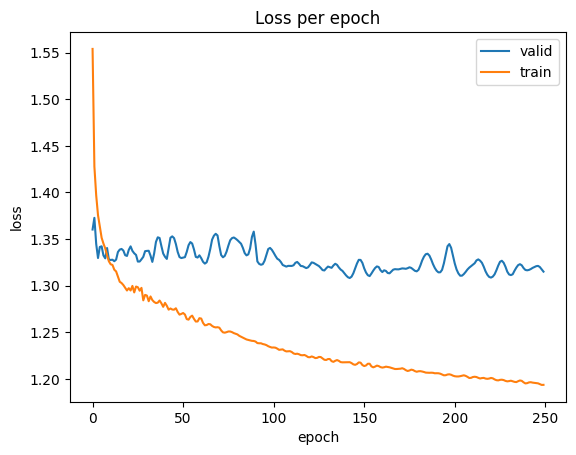

In [11]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

In [12]:
model.unfreeze_encoder_block()
best_model = train_model()

  0%|          | 1/250 [00:05<21:40,  5.22s/it]

Loss: 1.3119913339614868



  1%|          | 2/250 [00:09<20:07,  4.87s/it]

Loss: 1.3103797435760498



  1%|          | 3/250 [00:14<19:12,  4.67s/it]

Loss: 1.3112194538116455



  2%|▏         | 4/250 [00:18<18:45,  4.58s/it]

Loss: 1.3134053945541382



  2%|▏         | 5/250 [00:23<18:27,  4.52s/it]

Loss: 1.3155163526535034



  2%|▏         | 6/250 [00:27<18:15,  4.49s/it]

Loss: 1.31816828250885



  3%|▎         | 7/250 [00:31<18:05,  4.47s/it]

Loss: 1.3205116987228394



  3%|▎         | 8/250 [00:36<17:58,  4.45s/it]

Loss: 1.3216179609298706



  4%|▎         | 9/250 [00:40<17:51,  4.44s/it]

Loss: 1.3201698064804077



  4%|▍         | 10/250 [00:45<17:45,  4.44s/it]

Loss: 1.3163584470748901



  4%|▍         | 11/250 [00:49<17:41,  4.44s/it]

Loss: 1.3114579916000366



  5%|▍         | 12/250 [00:54<17:36,  4.44s/it]

Loss: 1.3085070848464966



  5%|▌         | 13/250 [00:58<17:32,  4.44s/it]

Loss: 1.308236002922058



  6%|▌         | 14/250 [01:03<17:28,  4.44s/it]

Loss: 1.3097091913223267



  6%|▌         | 15/250 [01:07<17:22,  4.44s/it]

Loss: 1.3135051727294922



  6%|▋         | 16/250 [01:11<17:18,  4.44s/it]

Loss: 1.3174126148223877



  7%|▋         | 17/250 [01:16<17:14,  4.44s/it]

Loss: 1.319792628288269



  7%|▋         | 18/250 [01:20<17:10,  4.44s/it]

Loss: 1.3200124502182007



  8%|▊         | 19/250 [01:25<17:06,  4.44s/it]

Loss: 1.318490982055664



  8%|▊         | 20/250 [01:29<17:01,  4.44s/it]

Loss: 1.3157185316085815



  8%|▊         | 21/250 [01:34<16:56,  4.44s/it]

Loss: 1.3129944801330566



  9%|▉         | 22/250 [01:38<16:51,  4.44s/it]

Loss: 1.3108652830123901



  9%|▉         | 23/250 [01:42<16:47,  4.44s/it]

Loss: 1.3095073699951172



 10%|▉         | 24/250 [01:47<16:43,  4.44s/it]

Loss: 1.3095759153366089



 10%|█         | 25/250 [01:51<16:38,  4.44s/it]

Loss: 1.3102983236312866



 10%|█         | 26/250 [01:56<16:34,  4.44s/it]

Loss: 1.3126734495162964



 11%|█         | 27/250 [02:00<16:29,  4.44s/it]

Loss: 1.3152356147766113



 11%|█         | 28/250 [02:05<16:25,  4.44s/it]

Loss: 1.316904902458191



 12%|█▏        | 29/250 [02:09<16:20,  4.44s/it]

Loss: 1.3175028562545776



 12%|█▏        | 30/250 [02:14<16:16,  4.44s/it]

Loss: 1.317375659942627



 12%|█▏        | 31/250 [02:18<16:12,  4.44s/it]

Loss: 1.3165202140808105



 13%|█▎        | 32/250 [02:22<16:07,  4.44s/it]

Loss: 1.3157329559326172



 13%|█▎        | 33/250 [02:27<16:02,  4.44s/it]

Loss: 1.3146857023239136



 14%|█▎        | 34/250 [02:31<15:58,  4.44s/it]

Loss: 1.3131757974624634



 14%|█▍        | 35/250 [02:36<15:53,  4.43s/it]

Loss: 1.3127931356430054



 14%|█▍        | 36/250 [02:40<15:49,  4.43s/it]

Loss: 1.3136447668075562



 15%|█▍        | 37/250 [02:45<15:45,  4.44s/it]

Loss: 1.3156646490097046



 15%|█▌        | 38/250 [02:49<15:40,  4.44s/it]

Loss: 1.317595362663269



 16%|█▌        | 39/250 [02:53<15:37,  4.44s/it]

Loss: 1.3171437978744507



 16%|█▌        | 40/250 [02:58<15:31,  4.44s/it]

Loss: 1.3143097162246704



 16%|█▋        | 41/250 [03:02<15:27,  4.44s/it]

Loss: 1.310969591140747



 17%|█▋        | 42/250 [03:07<15:23,  4.44s/it]

Loss: 1.3084115982055664



 17%|█▋        | 43/250 [03:11<15:19,  4.44s/it]

Loss: 1.3066765069961548



 18%|█▊        | 44/250 [03:16<15:15,  4.44s/it]

Loss: 1.3057552576065063



 18%|█▊        | 45/250 [03:20<15:09,  4.44s/it]

Loss: 1.3056517839431763



 18%|█▊        | 46/250 [03:25<15:05,  4.44s/it]

Loss: 1.305979609489441



 19%|█▉        | 47/250 [03:29<15:00,  4.44s/it]

Loss: 1.3076986074447632



 19%|█▉        | 48/250 [03:33<14:56,  4.44s/it]

Loss: 1.309823751449585



 20%|█▉        | 49/250 [03:38<14:52,  4.44s/it]

Loss: 1.312685489654541



 20%|██        | 50/250 [03:42<14:47,  4.44s/it]

Loss: 1.3160094022750854



 20%|██        | 51/250 [03:47<14:42,  4.43s/it]

Loss: 1.3183813095092773



 21%|██        | 52/250 [03:51<14:38,  4.44s/it]

Loss: 1.3181623220443726



 21%|██        | 53/250 [03:56<14:34,  4.44s/it]

Loss: 1.3164178133010864



 22%|██▏       | 54/250 [04:00<14:30,  4.44s/it]

Loss: 1.3142110109329224



 22%|██▏       | 55/250 [04:05<14:25,  4.44s/it]

Loss: 1.312968134880066



 22%|██▏       | 56/250 [04:09<14:21,  4.44s/it]

Loss: 1.3124828338623047



 23%|██▎       | 57/250 [04:13<14:16,  4.44s/it]

Loss: 1.3120665550231934



 23%|██▎       | 58/250 [04:18<14:12,  4.44s/it]

Loss: 1.3118339776992798



 24%|██▎       | 59/250 [04:22<14:08,  4.44s/it]

Loss: 1.3121041059494019



 24%|██▍       | 60/250 [04:27<14:02,  4.43s/it]

Loss: 1.3129055500030518



 24%|██▍       | 61/250 [04:31<13:58,  4.43s/it]

Loss: 1.3136850595474243



 25%|██▍       | 62/250 [04:36<13:52,  4.43s/it]

Loss: 1.313984751701355



 25%|██▌       | 63/250 [04:40<13:48,  4.43s/it]

Loss: 1.313154935836792



 26%|██▌       | 64/250 [04:44<13:44,  4.43s/it]

Loss: 1.311647891998291



 26%|██▌       | 65/250 [04:49<13:40,  4.43s/it]

Loss: 1.310224175453186



 26%|██▋       | 66/250 [04:53<13:35,  4.43s/it]

Loss: 1.309541940689087



 27%|██▋       | 67/250 [04:58<13:31,  4.44s/it]

Loss: 1.3101080656051636



 27%|██▋       | 68/250 [05:02<13:27,  4.44s/it]

Loss: 1.311016321182251



 28%|██▊       | 69/250 [05:07<13:23,  4.44s/it]

Loss: 1.312268853187561



 28%|██▊       | 70/250 [05:11<13:18,  4.44s/it]

Loss: 1.3136041164398193



 28%|██▊       | 71/250 [05:15<13:14,  4.44s/it]

Loss: 1.3144667148590088



 29%|██▉       | 72/250 [05:20<13:10,  4.44s/it]

Loss: 1.3153949975967407



 29%|██▉       | 73/250 [05:24<13:05,  4.44s/it]

Loss: 1.3153421878814697



 30%|██▉       | 74/250 [05:29<13:02,  4.44s/it]

Loss: 1.3139516115188599



 30%|███       | 75/250 [05:33<12:56,  4.44s/it]

Loss: 1.3119080066680908



 30%|███       | 76/250 [05:38<12:52,  4.44s/it]

Loss: 1.3106807470321655



 31%|███       | 77/250 [05:42<12:47,  4.44s/it]

Loss: 1.3100368976593018



 31%|███       | 78/250 [05:47<12:44,  4.45s/it]

Loss: 1.309489369392395



 32%|███▏      | 79/250 [05:51<12:39,  4.44s/it]

Loss: 1.309459924697876



 32%|███▏      | 80/250 [05:55<12:34,  4.44s/it]

Loss: 1.309268593788147



 32%|███▏      | 81/250 [06:00<12:30,  4.44s/it]

Loss: 1.3094065189361572



 33%|███▎      | 82/250 [06:04<12:25,  4.44s/it]

Loss: 1.3100829124450684



 33%|███▎      | 83/250 [06:09<12:22,  4.44s/it]

Loss: 1.3107973337173462



 34%|███▎      | 84/250 [06:13<12:17,  4.44s/it]

Loss: 1.3118642568588257



 34%|███▍      | 85/250 [06:18<12:11,  4.44s/it]

Loss: 1.3131000995635986



 34%|███▍      | 86/250 [06:22<12:07,  4.44s/it]

Loss: 1.3134835958480835



 35%|███▍      | 87/250 [06:27<12:03,  4.44s/it]

Loss: 1.3137143850326538



 35%|███▌      | 88/250 [06:31<11:58,  4.43s/it]

Loss: 1.3134804964065552



 36%|███▌      | 89/250 [06:35<11:53,  4.43s/it]

Loss: 1.3130534887313843



 36%|███▌      | 90/250 [06:40<11:48,  4.43s/it]

Loss: 1.3123266696929932



 36%|███▋      | 91/250 [06:44<11:44,  4.43s/it]

Loss: 1.3122047185897827



 37%|███▋      | 92/250 [06:49<11:40,  4.43s/it]

Loss: 1.3122793436050415



 37%|███▋      | 93/250 [06:53<11:36,  4.43s/it]

Loss: 1.3118356466293335



 38%|███▊      | 94/250 [06:58<11:32,  4.44s/it]

Loss: 1.310132622718811



 38%|███▊      | 95/250 [07:02<11:28,  4.44s/it]

Loss: 1.3069957494735718



 38%|███▊      | 96/250 [07:06<11:23,  4.44s/it]

Loss: 1.3044685125350952



 39%|███▉      | 97/250 [07:11<11:19,  4.44s/it]

Loss: 1.303672432899475



 39%|███▉      | 98/250 [07:15<11:14,  4.44s/it]

Loss: 1.30479896068573



 40%|███▉      | 99/250 [07:20<11:11,  4.44s/it]

Loss: 1.3068090677261353



 40%|████      | 100/250 [07:24<11:06,  4.44s/it]

Loss: 1.3090721368789673



 40%|████      | 101/250 [07:29<11:02,  4.45s/it]

Loss: 1.3100292682647705



 41%|████      | 102/250 [07:33<10:57,  4.44s/it]

Loss: 1.3098769187927246



 41%|████      | 103/250 [07:38<10:53,  4.44s/it]

Loss: 1.309687614440918



 42%|████▏     | 104/250 [07:42<10:48,  4.44s/it]

Loss: 1.3100422620773315



 42%|████▏     | 105/250 [07:46<10:43,  4.44s/it]

Loss: 1.3112808465957642



 42%|████▏     | 106/250 [07:51<10:38,  4.44s/it]

Loss: 1.3135898113250732



 43%|████▎     | 107/250 [07:55<10:34,  4.44s/it]

Loss: 1.3162230253219604



 43%|████▎     | 108/250 [08:00<10:30,  4.44s/it]

Loss: 1.3183525800704956



 44%|████▎     | 109/250 [08:04<10:26,  4.44s/it]

Loss: 1.3194373846054077



 44%|████▍     | 110/250 [08:09<10:21,  4.44s/it]

Loss: 1.3173754215240479



 44%|████▍     | 111/250 [08:13<10:17,  4.44s/it]

Loss: 1.3132011890411377



 45%|████▍     | 112/250 [08:18<10:12,  4.44s/it]

Loss: 1.3098633289337158



 45%|████▌     | 113/250 [08:22<10:08,  4.44s/it]

Loss: 1.3083912134170532



 46%|████▌     | 114/250 [08:26<10:03,  4.44s/it]

Loss: 1.3088712692260742



 46%|████▌     | 115/250 [08:31<09:58,  4.43s/it]

Loss: 1.3102095127105713



 46%|████▋     | 116/250 [08:35<09:54,  4.44s/it]

Loss: 1.3124812841415405



 47%|████▋     | 117/250 [08:40<09:49,  4.43s/it]

Loss: 1.3142071962356567



 47%|████▋     | 118/250 [08:44<09:45,  4.43s/it]

Loss: 1.3148930072784424



 48%|████▊     | 119/250 [08:49<09:40,  4.43s/it]

Loss: 1.3146575689315796



 48%|████▊     | 120/250 [08:53<09:36,  4.43s/it]

Loss: 1.3139264583587646



 48%|████▊     | 121/250 [08:57<09:32,  4.44s/it]

Loss: 1.3121938705444336



 49%|████▉     | 122/250 [09:02<09:27,  4.44s/it]

Loss: 1.3099240064620972



 49%|████▉     | 123/250 [09:06<09:23,  4.43s/it]

Loss: 1.3089927434921265



 50%|████▉     | 124/250 [09:11<09:19,  4.44s/it]

Loss: 1.309329867362976



 50%|█████     | 125/250 [09:15<09:14,  4.44s/it]

Loss: 1.3109182119369507



 50%|█████     | 126/250 [09:20<09:10,  4.44s/it]

Loss: 1.3130650520324707



 51%|█████     | 127/250 [09:24<09:06,  4.44s/it]

Loss: 1.3148618936538696



 51%|█████     | 128/250 [09:28<09:01,  4.44s/it]

Loss: 1.3153785467147827



 52%|█████▏    | 129/250 [09:33<08:57,  4.44s/it]

Loss: 1.3141423463821411



 52%|█████▏    | 130/250 [09:37<08:52,  4.44s/it]

Loss: 1.3114207983016968



 52%|█████▏    | 131/250 [09:42<08:48,  4.44s/it]

Loss: 1.3074663877487183



 53%|█████▎    | 132/250 [09:46<08:43,  4.44s/it]

Loss: 1.303965449333191



 53%|█████▎    | 133/250 [09:51<08:39,  4.44s/it]

Loss: 1.3029558658599854



 54%|█████▎    | 134/250 [09:55<08:34,  4.44s/it]

Loss: 1.3052595853805542



 54%|█████▍    | 135/250 [10:00<08:30,  4.44s/it]

Loss: 1.3100703954696655



 54%|█████▍    | 136/250 [10:04<08:25,  4.44s/it]

Loss: 1.3137067556381226



 55%|█████▍    | 137/250 [10:08<08:21,  4.44s/it]

Loss: 1.3150509595870972



 55%|█████▌    | 138/250 [10:13<08:17,  4.44s/it]

Loss: 1.313602089881897



 56%|█████▌    | 139/250 [10:17<08:13,  4.44s/it]

Loss: 1.3106927871704102



 56%|█████▌    | 140/250 [10:22<08:08,  4.44s/it]

Loss: 1.3072246313095093



 56%|█████▋    | 141/250 [10:26<08:03,  4.43s/it]

Loss: 1.304343819618225



 57%|█████▋    | 142/250 [10:31<07:58,  4.43s/it]

Loss: 1.3019510507583618



 57%|█████▋    | 143/250 [10:35<07:54,  4.43s/it]

Loss: 1.3017587661743164



 58%|█████▊    | 144/250 [10:39<07:49,  4.43s/it]

Loss: 1.304525375366211



 58%|█████▊    | 145/250 [10:44<07:45,  4.43s/it]

Loss: 1.3083770275115967



 58%|█████▊    | 146/250 [10:48<07:40,  4.43s/it]

Loss: 1.3117774724960327



 59%|█████▉    | 147/250 [10:53<07:36,  4.43s/it]

Loss: 1.3117520809173584



 59%|█████▉    | 148/250 [10:57<07:32,  4.44s/it]

Loss: 1.3073829412460327



 60%|█████▉    | 149/250 [11:02<07:28,  4.44s/it]

Loss: 1.302811622619629



 60%|██████    | 150/250 [11:06<07:24,  4.44s/it]

Loss: 1.2994064092636108



 60%|██████    | 151/250 [11:11<07:19,  4.44s/it]

Loss: 1.296801209449768



 61%|██████    | 152/250 [11:15<07:14,  4.44s/it]

Loss: 1.2958043813705444



 61%|██████    | 153/250 [11:19<07:10,  4.44s/it]

Loss: 1.297380805015564



 62%|██████▏   | 154/250 [11:24<07:06,  4.44s/it]

Loss: 1.300506591796875



 62%|██████▏   | 155/250 [11:28<07:01,  4.44s/it]

Loss: 1.3045591115951538



 62%|██████▏   | 156/250 [11:33<06:57,  4.44s/it]

Loss: 1.3085469007492065



 63%|██████▎   | 157/250 [11:37<06:52,  4.44s/it]

Loss: 1.312445044517517



 63%|██████▎   | 158/250 [11:42<06:48,  4.44s/it]

Loss: 1.315267562866211



 64%|██████▎   | 159/250 [11:46<06:44,  4.45s/it]

Loss: 1.3145755529403687



 64%|██████▍   | 160/250 [11:51<06:40,  4.45s/it]

Loss: 1.309149146080017



 64%|██████▍   | 161/250 [11:55<06:35,  4.44s/it]

Loss: 1.301252007484436



 65%|██████▍   | 162/250 [11:59<06:30,  4.44s/it]

Loss: 1.295939564704895



 65%|██████▌   | 163/250 [12:04<06:26,  4.44s/it]

Loss: 1.293185830116272



 66%|██████▌   | 164/250 [12:08<06:22,  4.45s/it]

Loss: 1.2918823957443237



 66%|██████▌   | 165/250 [12:13<06:17,  4.45s/it]

Loss: 1.2924565076828003



 66%|██████▋   | 166/250 [12:17<06:13,  4.44s/it]

Loss: 1.2942726612091064



 67%|██████▋   | 167/250 [12:22<06:08,  4.44s/it]

Loss: 1.2973520755767822



 67%|██████▋   | 168/250 [12:26<06:04,  4.44s/it]

Loss: 1.299861192703247



 68%|██████▊   | 169/250 [12:30<05:59,  4.44s/it]

Loss: 1.30138099193573



 68%|██████▊   | 170/250 [12:35<05:54,  4.43s/it]

Loss: 1.3012144565582275



 68%|██████▊   | 171/250 [12:39<05:50,  4.44s/it]

Loss: 1.2988712787628174



 69%|██████▉   | 172/250 [12:44<05:45,  4.43s/it]

Loss: 1.2957305908203125



 69%|██████▉   | 173/250 [12:48<05:41,  4.43s/it]

Loss: 1.2918375730514526



 70%|██████▉   | 174/250 [12:53<05:36,  4.43s/it]

Loss: 1.2887006998062134



 70%|███████   | 175/250 [12:57<05:32,  4.44s/it]

Loss: 1.2867487668991089



 70%|███████   | 176/250 [13:02<05:28,  4.43s/it]

Loss: 1.2861177921295166



 71%|███████   | 177/250 [13:06<05:23,  4.43s/it]

Loss: 1.287532925605774



 71%|███████   | 178/250 [13:10<05:19,  4.44s/it]

Loss: 1.2905317544937134



 72%|███████▏  | 179/250 [13:15<05:15,  4.44s/it]

Loss: 1.2937029600143433



 72%|███████▏  | 180/250 [13:19<05:10,  4.44s/it]

Loss: 1.2964228391647339



 72%|███████▏  | 181/250 [13:24<05:05,  4.43s/it]

Loss: 1.2979841232299805



 73%|███████▎  | 182/250 [13:28<05:01,  4.43s/it]

Loss: 1.2981634140014648



 73%|███████▎  | 183/250 [13:33<04:57,  4.44s/it]

Loss: 1.2966431379318237



 74%|███████▎  | 184/250 [13:37<04:53,  4.44s/it]

Loss: 1.2942142486572266



 74%|███████▍  | 185/250 [13:41<04:48,  4.44s/it]

Loss: 1.29192054271698



 74%|███████▍  | 186/250 [13:46<04:43,  4.44s/it]

Loss: 1.29202401638031



 75%|███████▍  | 187/250 [13:50<04:39,  4.44s/it]

Loss: 1.2936300039291382



 75%|███████▌  | 188/250 [13:55<04:35,  4.44s/it]

Loss: 1.2953025102615356



 76%|███████▌  | 189/250 [13:59<04:31,  4.44s/it]

Loss: 1.296683430671692



 76%|███████▌  | 190/250 [14:04<04:26,  4.44s/it]

Loss: 1.2990093231201172



 76%|███████▋  | 191/250 [14:08<04:21,  4.44s/it]

Loss: 1.3025931119918823



 77%|███████▋  | 192/250 [14:13<04:17,  4.44s/it]

Loss: 1.3059784173965454



 77%|███████▋  | 193/250 [14:17<04:12,  4.43s/it]

Loss: 1.3067883253097534



 78%|███████▊  | 194/250 [14:21<04:08,  4.44s/it]

Loss: 1.3045107126235962



 78%|███████▊  | 195/250 [14:26<04:04,  4.44s/it]

Loss: 1.3007656335830688



 78%|███████▊  | 196/250 [14:30<03:59,  4.43s/it]

Loss: 1.2972015142440796



 79%|███████▉  | 197/250 [14:35<03:54,  4.43s/it]

Loss: 1.2949732542037964



 79%|███████▉  | 198/250 [14:39<03:50,  4.43s/it]

Loss: 1.2943744659423828



 80%|███████▉  | 199/250 [14:44<03:45,  4.43s/it]

Loss: 1.2958177328109741



 80%|████████  | 200/250 [14:48<03:41,  4.42s/it]

Loss: 1.2985213994979858



 80%|████████  | 201/250 [14:52<03:37,  4.43s/it]

Loss: 1.3019953966140747



 81%|████████  | 202/250 [14:57<03:33,  4.44s/it]

Loss: 1.3049169778823853



 81%|████████  | 203/250 [15:01<03:28,  4.44s/it]

Loss: 1.3067559003829956



 82%|████████▏ | 204/250 [15:06<03:24,  4.44s/it]

Loss: 1.3072376251220703



 82%|████████▏ | 205/250 [15:10<03:19,  4.44s/it]

Loss: 1.30588698387146



 82%|████████▏ | 206/250 [15:15<03:15,  4.44s/it]

Loss: 1.3034579753875732



 83%|████████▎ | 207/250 [15:19<03:10,  4.44s/it]

Loss: 1.300362467765808



 83%|████████▎ | 208/250 [15:23<03:06,  4.43s/it]

Loss: 1.2971607446670532



 84%|████████▎ | 209/250 [15:28<03:01,  4.44s/it]

Loss: 1.2942960262298584



 84%|████████▍ | 210/250 [15:32<02:57,  4.44s/it]

Loss: 1.2921358346939087



 84%|████████▍ | 211/250 [15:37<02:53,  4.44s/it]

Loss: 1.2906187772750854



 85%|████████▍ | 212/250 [15:41<02:48,  4.44s/it]

Loss: 1.2902182340621948



 85%|████████▌ | 213/250 [15:46<02:44,  4.45s/it]

Loss: 1.2909879684448242



 86%|████████▌ | 214/250 [15:50<02:40,  4.45s/it]

Loss: 1.2929810285568237



 86%|████████▌ | 215/250 [15:55<02:35,  4.44s/it]

Loss: 1.2953912019729614



 86%|████████▋ | 216/250 [15:59<02:31,  4.44s/it]

Loss: 1.2967487573623657



 87%|████████▋ | 217/250 [16:03<02:26,  4.44s/it]

Loss: 1.2961819171905518



 87%|████████▋ | 218/250 [16:08<02:22,  4.44s/it]

Loss: 1.2936090230941772



 88%|████████▊ | 219/250 [16:12<02:17,  4.44s/it]

Loss: 1.2919450998306274



 88%|████████▊ | 220/250 [16:17<02:13,  4.44s/it]

Loss: 1.291061282157898



 88%|████████▊ | 221/250 [16:21<02:08,  4.44s/it]

Loss: 1.2910234928131104



 89%|████████▉ | 222/250 [16:26<02:04,  4.43s/it]

Loss: 1.291891098022461



 89%|████████▉ | 223/250 [16:30<01:59,  4.44s/it]

Loss: 1.2934569120407104



 90%|████████▉ | 224/250 [16:34<01:55,  4.43s/it]

Loss: 1.2955492734909058



 90%|█████████ | 225/250 [16:39<01:50,  4.44s/it]

Loss: 1.2975424528121948



 90%|█████████ | 226/250 [16:43<01:46,  4.43s/it]

Loss: 1.2985581159591675



 91%|█████████ | 227/250 [16:48<01:41,  4.43s/it]

Loss: 1.298892617225647



 91%|█████████ | 228/250 [16:52<01:37,  4.44s/it]

Loss: 1.2976950407028198



 92%|█████████▏| 229/250 [16:57<01:33,  4.44s/it]

Loss: 1.295245885848999



 92%|█████████▏| 230/250 [17:01<01:28,  4.44s/it]

Loss: 1.2922661304473877



 92%|█████████▏| 231/250 [17:06<01:24,  4.44s/it]

Loss: 1.290280818939209



 93%|█████████▎| 232/250 [17:10<01:19,  4.44s/it]

Loss: 1.2897908687591553



 93%|█████████▎| 233/250 [17:14<01:15,  4.44s/it]

Loss: 1.2904866933822632



 94%|█████████▎| 234/250 [17:19<01:11,  4.44s/it]

Loss: 1.2906793355941772



 94%|█████████▍| 235/250 [17:23<01:06,  4.45s/it]

Loss: 1.2915061712265015



 94%|█████████▍| 236/250 [17:28<01:02,  4.45s/it]

Loss: 1.291479468345642



 95%|█████████▍| 237/250 [17:32<00:57,  4.44s/it]

Loss: 1.2909996509552002



 95%|█████████▌| 238/250 [17:37<00:53,  4.44s/it]

Loss: 1.2898730039596558



 96%|█████████▌| 239/250 [17:41<00:48,  4.44s/it]

Loss: 1.2882368564605713



 96%|█████████▌| 240/250 [17:46<00:44,  4.44s/it]

Loss: 1.2874093055725098



 96%|█████████▋| 241/250 [17:50<00:39,  4.44s/it]

Loss: 1.2867043018341064



 97%|█████████▋| 242/250 [17:54<00:35,  4.44s/it]

Loss: 1.2867152690887451



 97%|█████████▋| 243/250 [17:59<00:31,  4.44s/it]

Loss: 1.2873836755752563



 98%|█████████▊| 244/250 [18:03<00:26,  4.44s/it]

Loss: 1.2879910469055176



 98%|█████████▊| 245/250 [18:08<00:22,  4.44s/it]

Loss: 1.2887829542160034



 98%|█████████▊| 246/250 [18:12<00:17,  4.44s/it]

Loss: 1.289838433265686



 99%|█████████▉| 247/250 [18:17<00:13,  4.44s/it]

Loss: 1.2909746170043945



 99%|█████████▉| 248/250 [18:21<00:08,  4.44s/it]

Loss: 1.2915067672729492



100%|█████████▉| 249/250 [18:25<00:04,  4.44s/it]

Loss: 1.2923557758331299



100%|██████████| 250/250 [18:30<00:00,  4.44s/it]

Loss: 1.293363094329834



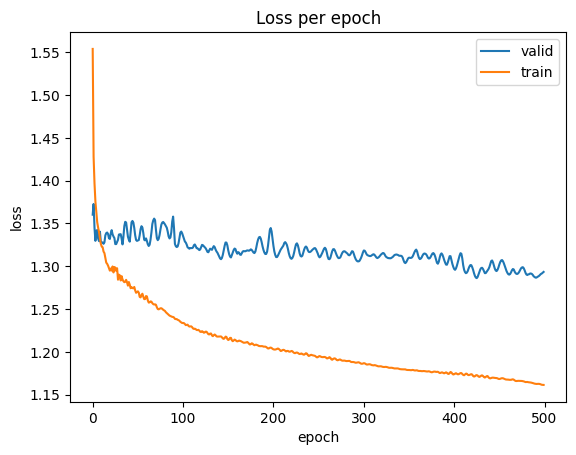

In [13]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

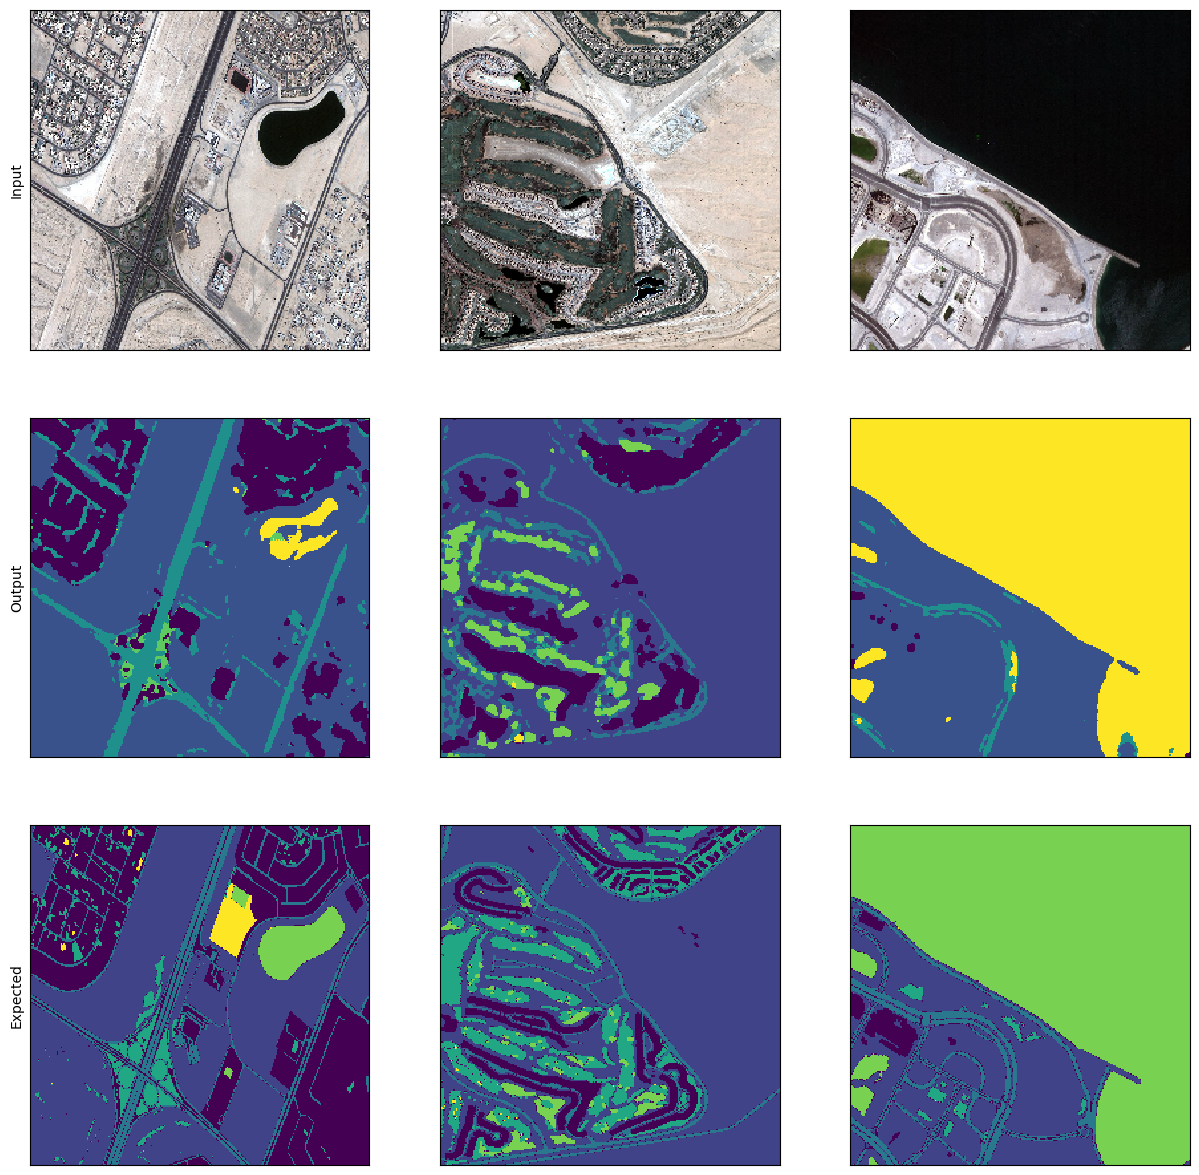

In [14]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])

        ax[1][j].imshow(torch.argmax(best_model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [15]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [16]:
iou_test = torch.zeros([1, 7]).to(device)

for instances, targets in test_loader:
    predict = torch.zeros(targets.shape).to(device)
    res = torch.argmax(best_model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[0.2887, 0.1960, 0.6522, 0.2147, 0.1450, 0.5241, 0.0000]],
       device='cuda:0')

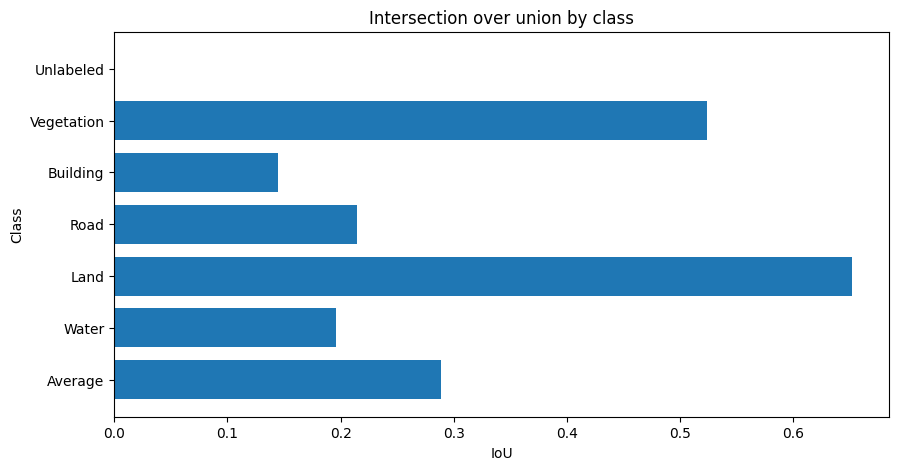

In [17]:
classes = ["Average", "Water", "Land", "Road", "Building", "Vegetation", "Unlabeled"]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 5))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [18]:
to_save = True

if to_save:
    torch.save(model.state_dict(), r"model\weights\best_pretrained_deconv_sun.zip")